In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

from statsforecast import StatsForecast
from statsforecast.models import (
    SeasonalNaive,
    RandomWalkWithDrift,
    AutoARIMA,
    AutoETS,
    AutoTheta,
)

from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate

from sklearn.linear_model import LinearRegression

import os


os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

In [51]:
df = pd.read_csv("train.csv")
df.info()

df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")
df["unique_id"] = "employment-fm"
df = df.rename(columns={"DATE": "ds", "y": "y"})
df = df[["unique_id", "ds", "y"]]

<class 'pandas.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    420 non-null    str    
 1   y       420 non-null    float64
dtypes: float64(1), str(1)
memory usage: 10.8 KB


In [52]:
df.tail()

,unique_id,ds,y
415,employment-fm,2024-08-01,1788.5
416,employment-fm,2024-09-01,1787.1
417,employment-fm,2024-10-01,1780.7
418,employment-fm,2024-11-01,1776.4
419,employment-fm,2024-12-01,1777.9


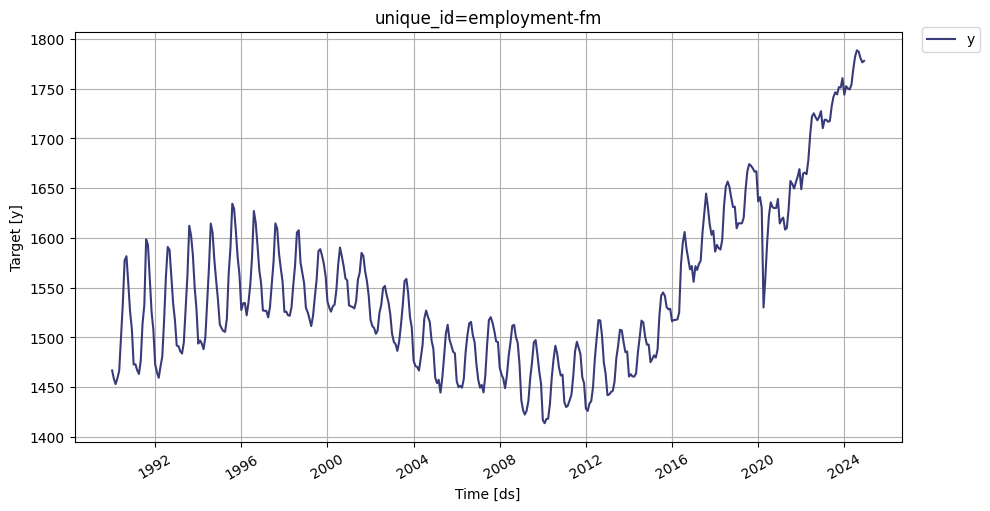

In [53]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

In [54]:
# simply cutoff from 2021 and forward
df = df[df["ds"] >= "2021-01-01"]

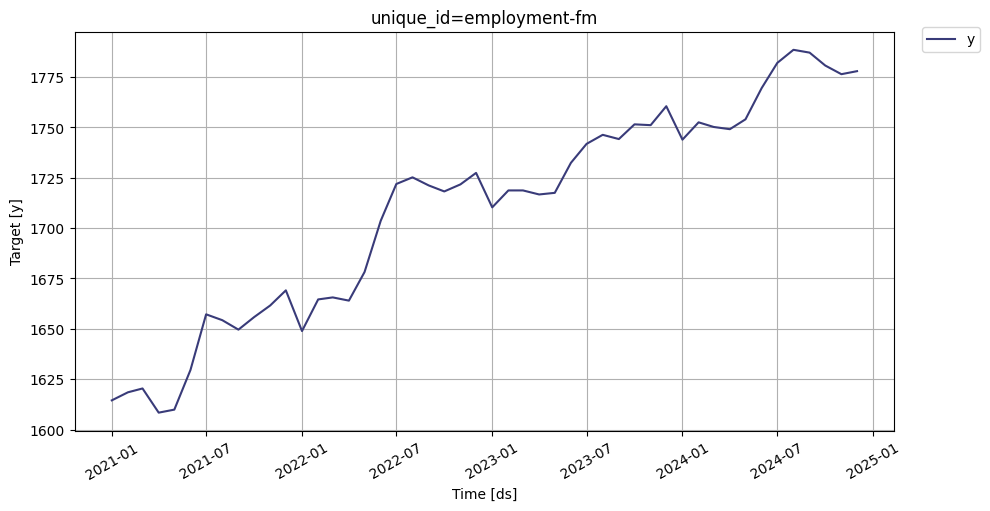

In [55]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

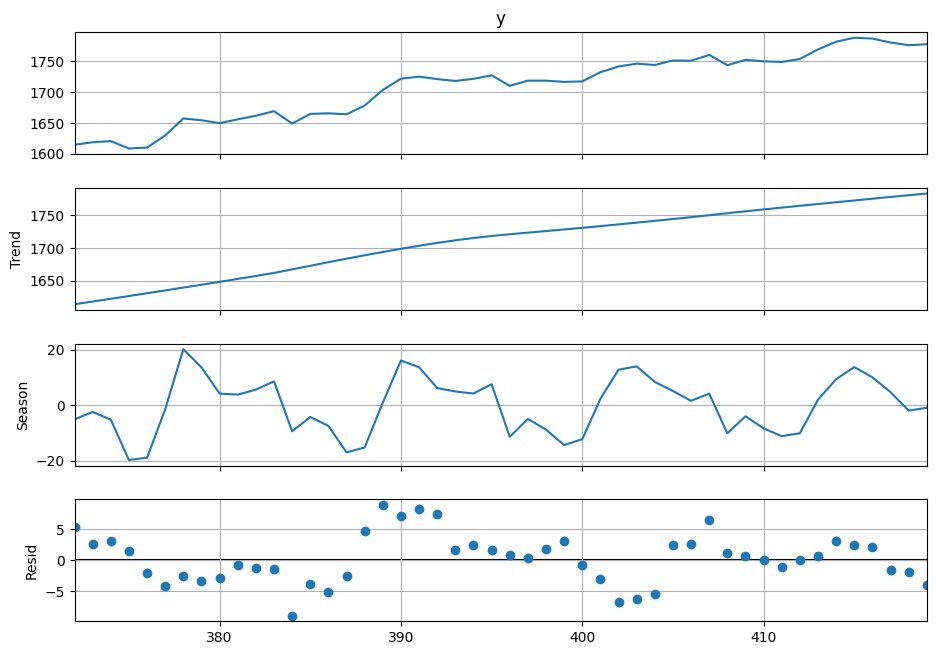

In [56]:
res = STL(df['y'], period=12).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

In [57]:
forecast_horizon = 12
season_length = 12

sf = StatsForecast(
    models=[
        SeasonalNaive(season_length=season_length),
        RandomWalkWithDrift(alias="RWD"),
        AutoARIMA(season_length=season_length),
        AutoETS(season_length=season_length),
        AutoTheta(season_length=season_length)
    ],
    freq="MS",
)

sf.fit(df)

# forecast horizon 12 months, still log-scaled
forecast_df = sf.predict(h=forecast_horizon)
forecast_df

,unique_id,ds,SeasonalNaive,RWD,AutoARIMA,AutoETS,AutoTheta
0,employment-fm,2025-01-01,1743.9,1781.376596,1761.073497,1781.401442,1781.637940
1,employment-fm,2025-02-01,1752.5,1784.853191,1769.582895,1784.902534,1785.305788
2,employment-fm,2025-03-01,1750.2,1788.329787,1768.324811,1788.403626,1788.973636
3,employment-fm,2025-04-01,1749.1,1791.806383,1766.817105,1791.904718,1792.641483
4,employment-fm,2025-05-01,1754.0,1795.282979,1769.859777,1795.405810,1796.309331
5,employment-fm,2025-06-01,1769.5,1798.759574,1785.087973,1798.906902,1799.977179
6,employment-fm,2025-07-01,1782.0,1802.236170,1796.183651,1802.407994,1803.645027
7,employment-fm,2025-08-01,1788.5,1805.712766,1801.777638,1805.909086,1807.312875
8,employment-fm,2025-09-01,1787.1,1809.189362,1800.060533,1809.410178,1810.980723
9,employment-fm,2025-10-01,1780.7,1812.665957,1799.866727,1812.911270,1814.648570


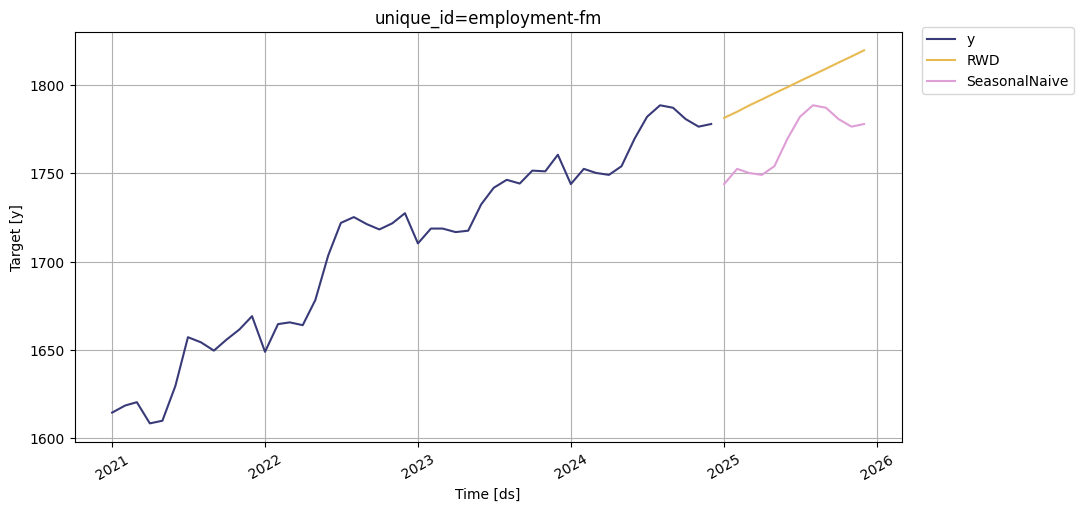

In [58]:
# two baselines
f = sf.plot(df, forecast_df, models=['RWD', 'SeasonalNaive'])
f.set_figwidth(9)
f.set_figheight(5)
f

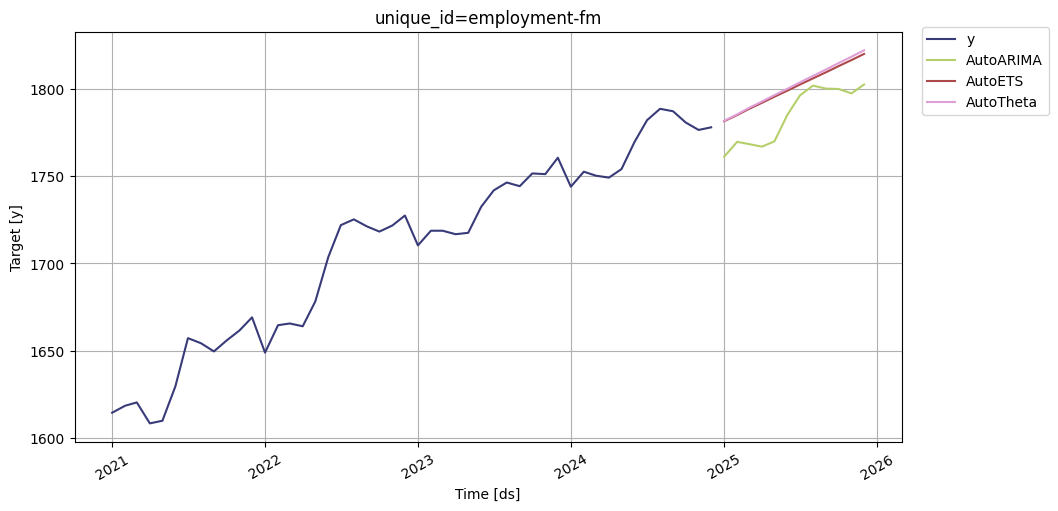

In [59]:
f = sf.plot(df, forecast_df, models=['AutoARIMA', 'AutoETS', 'AutoTheta'])
f.set_figwidth(9)
f.set_figheight(5)
f

In [60]:
# ensemble two baselines
forecast_df['RWD_SeasonalNaive'] = (
    (forecast_df['RWD'] + forecast_df['SeasonalNaive']) / 2
)

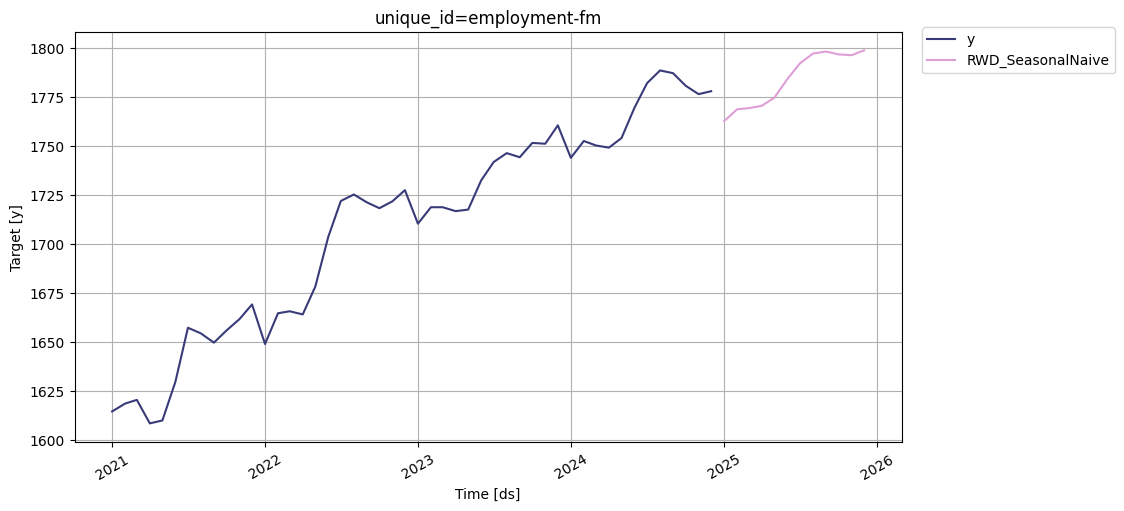

In [61]:
f = sf.plot(df, forecast_df, models=['RWD_SeasonalNaive'])
f.set_figwidth(9)
f.set_figheight(5)
f

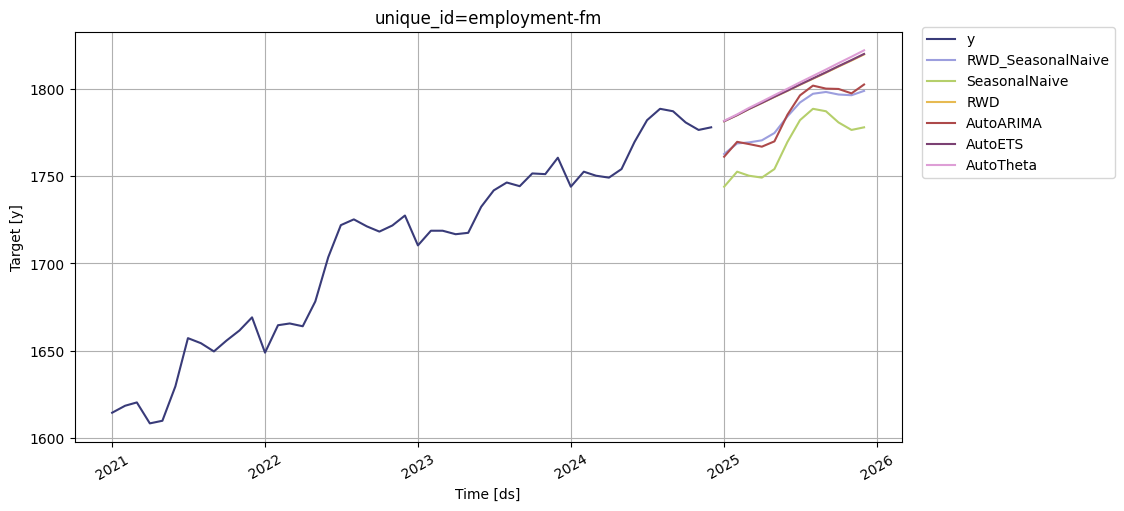

In [62]:
f = sf.plot(df, forecast_df, models=['RWD_SeasonalNaive', 'SeasonalNaive', 'RWD', 'AutoARIMA', 'AutoETS', 'AutoTheta'])
f.set_figwidth(9)
f.set_figheight(5)
f

#cross-validation 3 iterations

In [63]:
cv_df = sf.cross_validation(
    df=df,
    h=12,          # 12 months ahead
    step_size=12,  # move 1 year forward each iteration
    n_windows=3    # last 3 years as validation
)

cv_df['RWD_SeasonalNaive'] = (
    cv_df['RWD'] + cv_df['SeasonalNaive']
) / 2


cv_df.tail()

,unique_id,ds,cutoff,y,SeasonalNaive,RWD,AutoARIMA,AutoETS,AutoTheta,RWD_SeasonalNaive
31,employment-fm,2024-08-01,2023-12-01,1788.5,1746.3,1793.871429,1797.462823,1794.011473,1794.382097,1770.085714
32,employment-fm,2024-09-01,2023-12-01,1787.1,1744.2,1798.042857,1794.440260,1798.200473,1798.623750,1771.121429
33,employment-fm,2024-10-01,2023-12-01,1780.7,1751.5,1802.214286,1796.738994,1802.389472,1802.865402,1776.857143
34,employment-fm,2024-11-01,2023-12-01,1776.4,1751.1,1806.385714,1798.232677,1806.578471,1807.107055,1778.742857
35,employment-fm,2024-12-01,2023-12-01,1777.9,1760.5,1810.557143,1805.836106,1810.767471,1811.348707,1785.528571


In [64]:
eval_res = evaluate(cv_df, metrics=[mae, rmse], models=['RWD_SeasonalNaive', 'SeasonalNaive', 'RWD', 'AutoARIMA', 'AutoETS', 'AutoTheta'])
eval_res

,unique_id,cutoff,metric,RWD_SeasonalNaive,SeasonalNaive,RWD,AutoARIMA,AutoETS,AutoTheta
0,employment-fm,2021-12-01,mae,27.322348,59.300000,12.420455,33.158333,33.158583,13.295499
1,employment-fm,2022-12-01,mae,6.578804,37.433333,25.164855,25.164855,15.925095,28.107650
2,employment-fm,2023-12-01,mae,8.433929,33.508333,19.964286,10.057886,20.077974,20.369619
3,employment-fm,2021-12-01,rmse,29.887615,60.434524,15.075669,39.755010,39.755531,15.591950
4,employment-fm,2022-12-01,rmse,9.556708,39.902673,25.579097,25.579097,17.716053,28.586340
5,employment-fm,2023-12-01,rmse,10.040164,34.223347,21.697837,12.770065,21.805407,22.083877


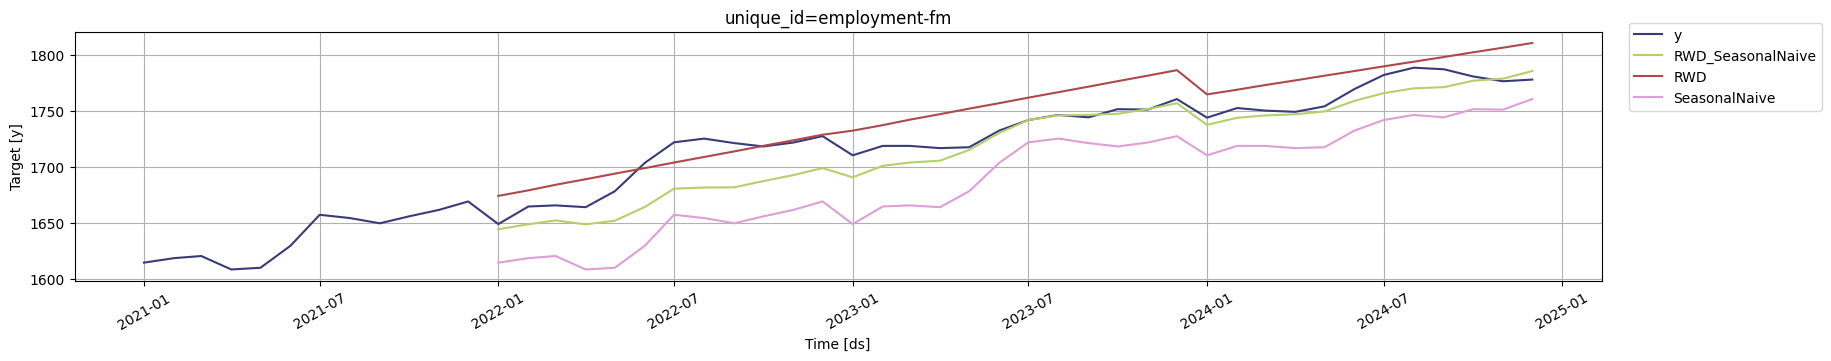

In [65]:
StatsForecast.plot(
    df,
    cv_df[['unique_id', 'ds', 'RWD_SeasonalNaive', 'RWD', 'SeasonalNaive']]
)

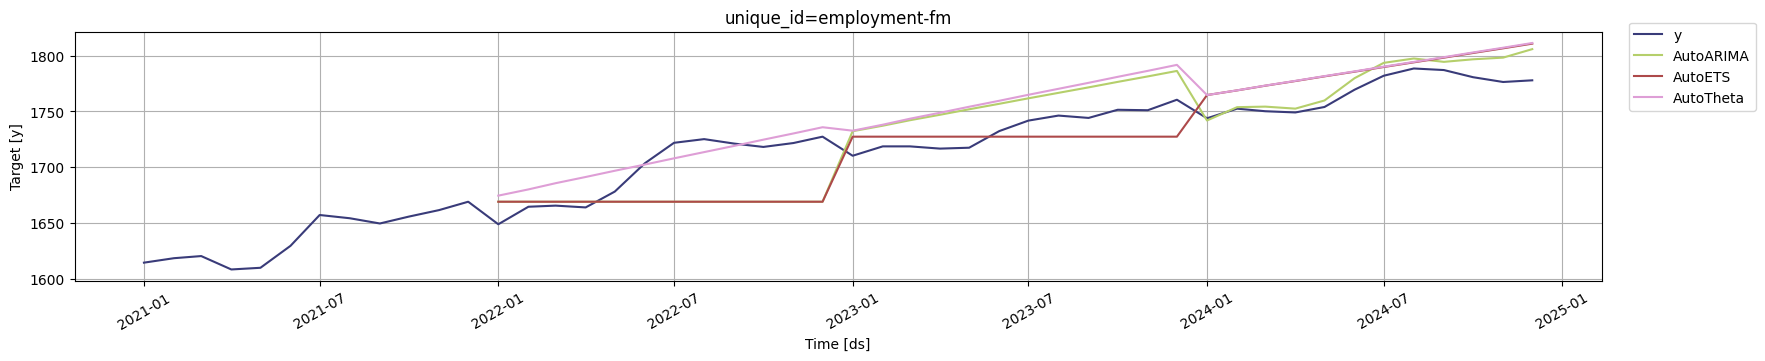

In [66]:
StatsForecast.plot(
    df,
    cv_df[['unique_id', 'ds', 'AutoARIMA', 'AutoETS', 'AutoTheta']]
)

#### Best Approach 1

In [67]:
print(forecast_df['RWD_SeasonalNaive'])

0     1762.638298
1     1768.676596
2     1769.264894
3     1770.453191
4     1774.641489
5     1784.129787
6     1792.118085
7     1797.106383
8     1798.144681
9     1796.682979
10    1796.271277
11    1798.759574
Name: RWD_SeasonalNaive, dtype: float64


#### Best Approach 2

Extrapolate trend + Last season pattern + 0 mean residual

In [68]:
trend = res.trend
season = res.seasonal
residual = res.resid

In [69]:
X = np.arange(len(trend)).reshape(-1, 1)
y = trend.values

# Simple Linear Regression Extrapolation
model = LinearRegression().fit(X, y)

X_future = np.arange(len(trend), len(trend) + forecast_horizon).reshape(-1, 1)
trend_f = model.predict(X_future)

In [70]:
# simply take the last seasonal pattern
seasonal_pattern = season[-season_length:].values
seasonal_f = np.tile(seasonal_pattern, forecast_horizon // season_length + 1)[:forecast_horizon]

In [71]:
forecast_2 = trend_f + seasonal_f

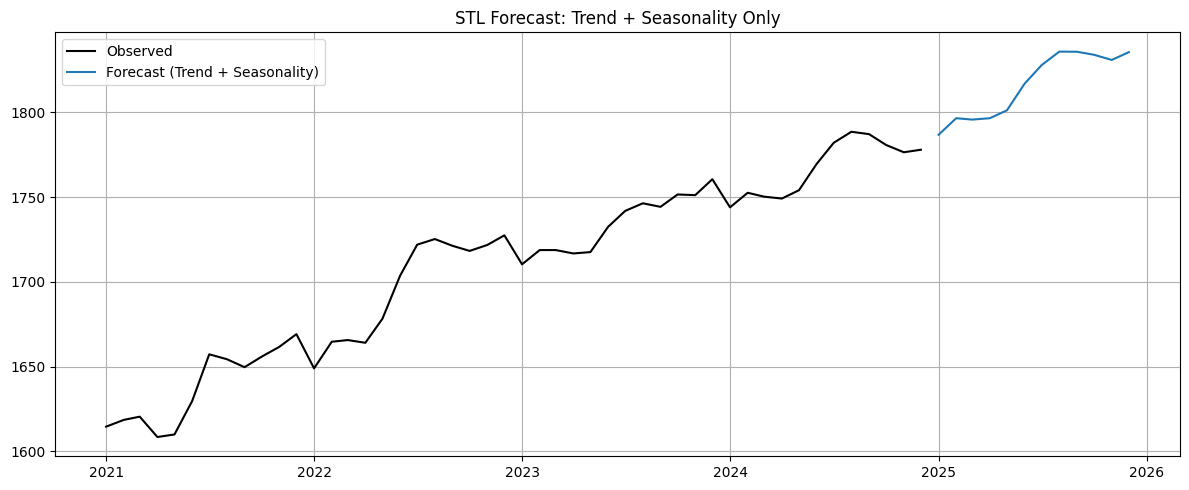

In [72]:
h = len(forecast_2)

# Build future monthly index
future_ds = pd.date_range(
    start=df["ds"].iloc[-1],
    periods=h + 1,
    freq="MS"
)[1:]


plt.figure(figsize=(12, 5))

# Old data
plt.plot(df["ds"], df["y"], label="Observed", color="black")

# Forecast
plt.plot(
    future_ds,
    forecast_2,
    label="Forecast (Trend + Seasonality)",
    linestyle="-"
)

plt.legend()
plt.title("STL Forecast: Trend + Seasonality Only")
plt.tight_layout()
plt.show()


Not bad

In [ ]:
forecast_using_stl = pd.Series(
    forecast_2,
    index=range(len(forecast_2)),
    name="Trend_Seasonal"
)

forecast_using_stl

0     1786.728833
1     1796.494395
2     1795.683010
3     1796.494378
4     1801.138114
5     1816.860112
6     1827.858006
7     1835.796827
8     1835.704438
9     1833.916413
10    1830.869738
11    1835.491780
Name: Trend_Seasonal, dtype: float64